# Testing for calculating slope

In [1]:
from qgis.core import (
    QgsApplication,
    QgsVectorLayer,
    QgsRasterLayer,
)

import processing
from processing.core.Processing import Processing

from customProvider import CustomProvider

# Initialize QGIS
qgs = QgsApplication([], False)
qgs.initQgis()

# Initialize processing plugin
Processing.initialize()  # TODO: 會自動生成processing folder，再處理一下

# Add the custom provider and custom algorithms
provider = CustomProvider()
QgsApplication.processingRegistry().addProvider(provider)

# Model input
dtm = QgsRasterLayer(r"dataset\DTMerge.tif", "DTMerge", "gdal")
grid_layer = QgsVectorLayer(r"dataset\FET_2023_grid_97.geojson", "grid", "ogr")

params = {
    "contourinterval": 10,
    "dtm": dtm,
    "grid": grid_layer,
    "gridinterval": 250,
    "Output": "TEMPORARY_OUTPUT",
}

result = processing.run("customProvider:calculate_slope", params)
print("RESULT:", result)
# print("output:", output)

qgs.exitQgis()


10.0 250.0
RESULT: {'Output': <QgsVectorLayer: 'Calculated' (memory)>}


Get the field name of the output

In [2]:
for field in result['Output'].fields():
    print(field.name(), field.typeName())

id integer
left double
top double
right double
bottom double
gridid integer
center_x double
center_y double
Area double
fid_count integer
ID_count integer
ELEV_count integer
id_2_count integer
left_count integer
top_count integer
right_count integer
bottom_count integer
gridid_count integer
center_x_count integer
center_y_count integer
Area_count integer
Slope double
class integer


Converting QgsVectorLayer to pandas dataframe

In [2]:
from qgis.core import (
    QgsFeatureRequest,
)
import pandas as pd

# request = QgsFeatureRequest()
layer = result['Output']
target_field_name = ['gridid', 'Slope', 'class']
data_container = []

for feature in result['Output'].getFeatures():
    values = [feature[field_name] for field_name in target_field_name]
    data_container.append(values)

df = pd.DataFrame(data_container, columns=target_field_name)
df

,gridid,Slope,class
0,610003,15.70,3
1,609703,0.00,1
2,609400,0.00,1
3,611469,14.13,2
4,611182,18.84,3
...,...,...,...
4304,597412,56.52,6
4305,597012,54.95,5
4306,596610,56.52,6
4307,597413,59.66,6


# Testing for merging DTM files

## Create a memory file instead of a output file

In [18]:
import glob
# from osgeo import gdal
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.transform import from_origin, from_bounds
from rasterio.crs import CRS
from rasterio.plot import show
import numpy as np

input_files = [file for file in glob.glob(r'dataset\分幅_臺北市20MDEM\*.grd')]
output_file = r'dataset\DTMerge2.tif'

new_crs = CRS({'init': 'epsg:3826'})

# Create a memory file to merge the DTM files
with MemoryFile() as memfile:
    datasets = []
    nodata_value = 0.0
    for file in input_files[:3]:
        with rio.open(file) as src:
            bounds = src.bounds
            res = src.res
            # Set the affine
            # new_transform = from_origin(bounds[2], bounds[3], res[0], res[1])
            # new_transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.width, src.height)
            new_transform = rio.Affine(res[0], 0, bounds[0], 0, -res[1], bounds[1])

            # Update the new meta
            new_meta = src.meta.copy()
            new_meta.update({
                'driver': 'XYZ',
                'crs': new_crs,
                'transform': new_transform, 
                'nodata': nodata_value,
            })
            print(new_meta)
            data = src.read()
            dataset = memfile.open(**new_meta)

            # Flipping the array of data (up down)
            dataset.write(np.array([np.flipud(data[0])]))
            datasets.append(dataset)

    # Output the file
    merge(datasets, nodata=0, dst_path=output_file)

    # Output the variable
    # mosaic_data, mosaic_transform = merge(datasets, nodata=nodata_value)

# show(mosaic_data, cmap='terrain')


{'driver': 'XYZ', 'dtype': 'float32', 'nodata': 0.0, 'width': 131, 'height': 143, 'count': 1, 'crs': CRS.from_epsg(3826), 'transform': Affine(20.0, 0.0, 298630.0,
       0.0, -20.0, 2787870.0)}
{'driver': 'XYZ', 'dtype': 'float32', 'nodata': 0.0, 'width': 130, 'height': 143, 'count': 1, 'crs': CRS.from_epsg(3826), 'transform': Affine(20.0, 0.0, 296130.0,
       0.0, -20.0, 2785090.0)}
{'driver': 'XYZ', 'dtype': 'float32', 'nodata': 0.0, 'width': 130, 'height': 143, 'count': 1, 'crs': CRS.from_epsg(3826), 'transform': Affine(20.0, 0.0, 298650.0,
       0.0, -20.0, 2785110.0)}


Take a look of the merged file

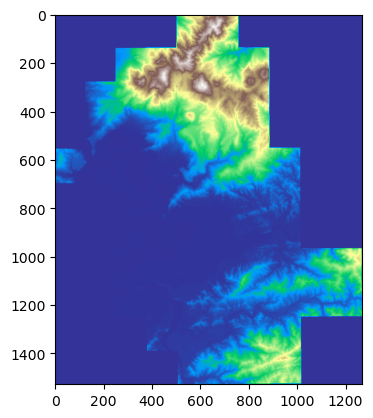

In [17]:
# Still can't let 'no data' pixel remain as 'no data' rather than be set to 0.
with rio.open(r"dataset\DTMerge.tif") as src:
    data = src.read()
    show(data, cmap='terrain')

## Using gdal.Warp() to merge the DTM files

In [3]:
from osgeo import gdal
import glob
# from osgeo import gdal
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.transform import from_origin, from_bounds
from rasterio.crs import CRS
from rasterio.plot import show
import numpy as np
#　Options for preprocessing
input_files = [file for file in glob.glob(r'dataset\分幅_臺北市20MDEM\*.grd')]
processing_options = gdal.WarpOptions(
    format='VRT',  # 使用虛擬格式，不輸出文件
    dstSRS='EPSG:3826',
    dstNodata=0,
)
# 進行處理但不輸出

in_memory_vrt_path = '/vsimem/merged.vrt'
g = gdal.Warp(in_memory_vrt_path, input_files, options=processing_options)

In [7]:
from qgis.core import QgsRasterLayer

layer = QgsRasterLayer(in_memory_vrt_path, "Merged Layer", "gdal")

# 清理vsimem虛擬文件
gdal.Unlink(in_memory_vrt_path)

0

In [10]:
layer.width()

1268

# Testing for using "grass7:r.recode" 
(the process of calculating NDVI)

Still can't using grass inside of the conda environment

In [3]:
import processing
processing.algorithmHelp("grass7:r.recode")

Algorithm "grass7:r.recode" not found.


I can register the Grass7AlgorithmProvider; however, there aren't any algorithms inside of this provider. I don't know why.

In [ ]:
from qgis.core import QgsApplication
from processing.core.Processing import Processing
from QgsCustomAlgorithms.customProvider import CustomProvider
from grassprovider.Grass7AlgorithmProvider import Grass7AlgorithmProvider

qgs = QgsApplication([], False)
qgs.initQgis()
    # Initialize QGIS processing framework
Processing.initialize()
provider = CustomProvider()
QgsApplication.processingRegistry().addProvider(provider)
QgsApplication.processingRegistry().addProvider(Grass7AlgorithmProvider())
for alg in QgsApplication.processingRegistry().algorithms():
    print("{}:{} --> {}".format(alg.provider().name(), alg.name(), alg.displayName()))

In [ ]:
# Test for the function replace grass r.recode


from qgis.core import QgsApplication
from processing.core.Processing import Processing
# from grassprovider.Grass7AlgorithmProvider import Grass7AlgorithmProvider
# import sys

qgs = QgsApplication([], False)
qgs.initQgis()



Processing.initialize()
p_reg = QgsApplication.processingRegistry()
algorithms = p_reg.algorithms()
providers = p_reg.providers()

for provider in providers:
    p_algorithms = provider.algorithms()
    print(provider.name())
    print([alg.name() for alg in p_algorithms])
# # print(algorithms)

qgs.exitQgis()
# provider = Grass7AlgorithmProvider()
# QgsApplication.processingRegistry().addProvider(provider)


In [ ]:
import processing
processing.algorithmHelp('grass7:r.clump')

In [ ]:
import sys
sys.path

In [ ]:
# Testing for rewriting r.recode()
from qgis.core import (
    QgsRasterLayer,
)
from PyQt5.QtCore import QFileInfo 
import rasterio as rio
from rasterio.transform import from_origin

with rio.open("input/data/terrain/DTMerge.tif") as src:
    data = src.read(1)
    threshold = 100
    classified_data = (data>=threshold).astype('int16')
    transform = from_origin(src.bounds.left, src.bounds.top,src.res[0],src.res[1])
    meta = src.meta.copy()
    print(classified_data)
    # with rio.open('test.tif','w',**meta) as dst:
    #     dst.write(raclassified_data,1)
    
    
# raster = "input/data/terrain/DTMerge.tif"
# fileInfo = QFileInfo(raster)
# path = fileInfo.filePath()
# baseName = fileInfo.baseName()

# ndvi_layer = QgsRasterLayer(
#     path, baseName
# )
# provider = ndvi_layer.dataProvider()
# block = provider.block(
#     1, ndvi_layer.extent(), ndvi_layer.width(), ndvi_layer.height()
# )
# stats = provider.bandStatistics(1, QgsRasterBandStats.All)
# block.value(10000,1000)
# if not ndvi_layer.isValid():
#     print("Raster layer is not valid.")
# ndvi_layer.extent()

# Testing for aggregating POI (By QGIS Algorithms)

In [1]:
# Test for POI

from qgis.core import QgsApplication
from processing.core.Processing import Processing
from QgsCustomAlgorithms.customProvider import CustomProvider
from grassprovider.Grass7AlgorithmProvider import Grass7AlgorithmProvider

qgs = QgsApplication([], False)
qgs.initQgis()
    # Initialize QGIS processing framework
Processing.initialize()
provider = CustomProvider()
QgsApplication.processingRegistry().addProvider(provider)

import glob
from PyQt5.QtCore import QVariant
from qgis.core import (
    QgsVectorLayer,
    QgsFields,
    QgsField,
    QgsCoordinateReferenceSystem,
    QgsPointXY,
    QgsGeometry,
    QgsFeature,
    QgsWkbTypes,
    QgsMemoryProviderUtils
)

import re
import pandas as pd
import geopandas as gpd
import processing
from QgsCustomAlgorithms.generalFunction import convert_csv_to_QgsVectorLayer, QgsVectorLayer_to_dataframe

grid_fp = r"input\data\population\FET_2023_grid_97.geojson"
# grid = gpd.read_file(grid_fp)

poi_category = [file for file in glob.glob(r"input\data\POI\*.csv")]

column_definition = {
    'rating_num':'Int',
    'rating':'Double',
}

layer_name = re.search(r"poi_(.*?)\.csv", poi_category[0]).group(1)
vlyr = convert_csv_to_QgsVectorLayer(
    poi_category[0], # filepath
    layer_name,  
    'lat',  # The latitude column name in the original dataset
    'lng',  # The longitude column name in the original dataset
    **column_definition # The column wanted to be extracted {name: QVarint type}
)

params = {
    'filternumber':5,
    'grid':grid_fp,
    'pois':[vlyr],
    'Output' : 'TEMPORARY_OUTPUT',
}

result = processing.run("customProvider:Aggregate_poi_to_grid", params)
print(result)

target_fields = ['gridid','rating_num_count','rating_num_sum','rating_star_sum']

df = QgsVectorLayer_to_dataframe(result['Output'],target_fields)
print(df)

qgs.exitQgis()


{'Output': <QgsVectorLayer: 'Refactored' (memory)>}


# Testing for aggregating Bus stops (By QGIS Algorithms)

In [1]:
from QgsCustomAlgorithms.generalFunction import csv_to_QgsVectorLayer, QgsVectorLayer_to_dataframe
from qgis.core import QgsApplication
import processing
from processing.core.Processing import Processing
from QgsCustomAlgorithms.customProvider import CustomProvider

qgs = QgsApplication([], False)
qgs.initQgis()
# Initialize QGIS processing framework
Processing.initialize()
provider = CustomProvider()
QgsApplication.processingRegistry().addProvider(provider)


TrafficFilePath = "input/data/traffic/bus_station_detailed.csv"
grid_fp = r"input\data\population\FET_2023_grid_97.geojson"

column_definition = {
    'RouteNum':'Int',
}

bus_station_points = csv_to_QgsVectorLayer(
    TrafficFilePath, 
    "bus_station_points",
    "lat",
    "lon",
    **column_definition
)

params = {
    'busstation': bus_station_points,
    'grid': grid_fp,
    'Output': 'TEMPORARY_OUTPUT'
}

result = processing.run("customProvider:aggregate_station_to_grid", params)

df = QgsVectorLayer_to_dataframe(result['Output'], ['gridid','RouteNum_sum'])
df


,gridid,RouteNum_sum
0,610003,0
1,609703,0
2,609400,0
3,611469,0
4,611182,2
...,...,...
4304,597412,0
4305,597012,2
4306,596610,0
4307,597413,2


# Testing for spatial index
landuse and development

In [41]:
import geopandas as gpd

landuse = gpd.read_file(r"input\data\land\landuse_108.gpkg", layer='landuse_108').set_crs('epsg:3826')
grid = gpd.read_file(r"input\data\population\FET_2023_grid_97.geojson").set_crs('epsg:3826')

,code,geometry
0,106,"MULTIPOLYGON (((311317.604 2762008.903, 311317..."
1,20200,"MULTIPOLYGON (((311205.604 2761891.903, 311205..."
2,102,"MULTIPOLYGON (((311322.604 2762017.903, 311322..."
3,103,"MULTIPOLYGON (((311244.604 2761899.903, 311244..."
4,20300,"MULTIPOLYGON (((311335.604 2761903.903, 311331..."


In [270]:
# mapping landuse code to landuse category code
import constants
landuse["mapping_category"] = landuse["code"].map(
    lambda code: constants.LANDUSE_CATEGORY.get(str(code), "unknown")
)

In [337]:
## Step 1 building intersection by grid
# build spatial index for the grid
# grid = grid.set_crs('epsg:3826')
grid_sindex = grid.sindex

# Using spatial index to intersects
idx = grid_sindex.query(landuse['geometry'], predicate='intersects')

In [338]:
import pandas as pd
newDF = pd.DataFrame(columns=['gridid', 'code', 'category','area','geometry'])
row_list = []

for index, (inputIdx, treeIdx) in enumerate(zip(idx[0],idx[1])): # idx[0]:input geometry, idx[1]:tree geometry
    selected_input = landuse.iloc[inputIdx]
    selected_tree = grid.iloc[treeIdx]
    intersects = selected_input.geometry.intersection(selected_tree.geometry)
    if intersects.geom_type in ['Polygon','MultiPolygon']:
        gridid = selected_tree['gridid']
        code = selected_input['code'] # keep code for building intersection
        category = selected_input['mapping_category']
        area = intersects.area
        geometry = intersects  # keep geometry for building intersection
        row = {'gridid':gridid, 'code':code, 'category':category,'area':area, 'geometry':geometry}
        row_list.append(row)
    if not index%10000:
        print(index)
    
newDF = pd.concat([newDF, pd.DataFrame(row_list)],ignore_index=True)
newDF

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000


,gridid,code,category,area,geometry
0,585891,106,1,245.0,"MULTIPOLYGON (((311317.6043 2762009.9032, 3113..."
1,585891,20200,1,50180.0,"MULTIPOLYGON (((311205.6043 2761890.9032, 3112..."
2,585891,102,1,172.0,"POLYGON ((311322.6043 2762018.9032, 311321.604..."
3,585891,103,1,4566.0,"POLYGON ((311244.6043 2761898.9032, 311244.604..."
4,585891,20300,1,6789.0,"POLYGON ((311331.6043 2761903.9032, 311331.604..."
...,...,...,...,...,...
37609,617299,20200,1,62500.0,"POLYGON ((308420.6043 2787379.9032, 308420.604..."
37610,617300,20200,1,62500.0,"POLYGON ((308670.6043 2787379.9032, 308670.604..."
37611,617435,90200,1,1922.0,"POLYGON ((308537.6043 2787581.9032, 308537.604..."
37612,617435,20200,1,56902.0,"MULTIPOLYGON (((308549.6043 2787536.9032, 3085..."


In [307]:
newDF['area']

0          245.0
1        50180.0
2          172.0
3         4566.0
4         6789.0
          ...   
37609    62500.0
37610    62500.0
37611     1922.0
37612    56902.0
37613     3676.0
Name: area, Length: 37614, dtype: float64

In [297]:
building = gpd.read_file(r'input\data\development\building.gpkg')

In [298]:
# Fix geometry
building.geometry = building.geometry.buffer(0)

In [308]:
newDF = gpd.GeoDataFrame(newDF, geometry='geometry').set_crs('epsg:3826')
newDF_sindex = newDF.sindex

In [309]:
idx = newDF_sindex.query(building.geometry, predicate='intersects')

In [325]:
buildingDF = pd.DataFrame(columns=['gridid','code','area','floor','geometry'])
row_list = []

for index, (inputIdx, treeIdx) in enumerate(zip(idx[0],idx[1])): # idx[0]:input geometry, idx[1]:tree geometry
    selected_input = building.iloc[inputIdx]
    selected_tree = newDF.iloc[treeIdx]
    intersects = selected_input.geometry.intersection(selected_tree.geometry)

    # eliminate invalid types
    if intersects.geom_type in ['Polygon','MultiPolygon']: 
        floor = selected_input['1_floor']
        if floor:
            gridid = selected_tree['gridid']
            code = selected_tree['code']
            area = intersects.area
            geometry = intersects
            row = {'gridid':gridid, 'code':code, 'area':area, 'floor':floor,'geometry':geometry}
            row_list.append(row)
    if not index%10000:
        print(index)

buildingDF = pd.concat([buildingDF, pd.DataFrame(row_list)],ignore_index=True)
buildingDF

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000


,gridid,code,area,floor,geometry
0,611470,602,0.097297,2.0,MULTIPOLYGON (((296796.6043 2779470.5515984455...
1,611470,50200,50.027111,2.0,"POLYGON ((296787.0720661837 2779468.314317708,..."
2,611470,602,74.277659,6.0,POLYGON ((296795.34644769004 2779458.306960100...
3,610892,50600,21.276537,1.0,"POLYGON ((296800.0000000011 2778900, 296795.02..."
4,609405,50200,4.066717,2.0,"POLYGON ((297429.6043 2777817.6268781493, 2974..."
...,...,...,...,...,...
578936,610003,50600,2.392948,1.0,POLYGON ((296186.50402175065 2778301.457954852...
578937,610003,20200,0.001279,1.0,"POLYGON ((296184.6043 2778300.043635577, 29618..."
578938,610598,50600,18.139415,1.0,"POLYGON ((296755.9841269471 2778868.741238581,..."
578939,610598,50600,7.482790,1.0,"POLYGON ((296752.5407835416 2778842.053551428,..."


In [378]:
buildingDF_pt

code,101,102,103,105,106,204,206,302,303,304,...,60100,60300,60400,60600,70103,70200,80200,90200,90400,sum
gridid,,,,,,,,,,,,,,,,,,,,,
585873,0.0,6.563749,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,153.100201
585874,0.0,0.000941,0.000000,0.0,7.677439,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,359.500719
585876,0.0,1.700153,6.067336,0.0,26.781599,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,29.585148,0.0,0.0,0.0,0.0,0.000000,0.0,207.717499
585877,0.0,1.595277,0.000000,0.0,57.421269,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,183.953473
585883,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,16.983765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617021,0.0,0.000000,1.919377,0.0,190.578228,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,462.795737
617148,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,67.244866
617153,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,372.202985


In [407]:
BUILDING_CATEGORY = {
    50200: "residential",  # 純住宅
    503: "mixed_residential",  # 混合使用住宅
    501: "commercial",  # 商業
}

buildingDF['floor_area'] = buildingDF['floor']* buildingDF['area']
buildingDF_pt = buildingDF.pivot_table(
    index='gridid', columns='code', values="floor_area", aggfunc="sum"
).fillna(0)

# Sum of total building area
buildingDF_pt['all'] = buildingDF_pt.sum(axis=1)

# Filter selected columns
selected_category = [key for key in BUILDING_CATEGORY.keys()]

building_category = selected_category.copy()
building_category.append('all')

# Filtered table
buildingDF_pt = buildingDF_pt[building_category]
buildingDF_pt['others'] = buildingDF_pt['all'] - buildingDF_pt.loc[:,selected_category].sum(axis=1)  # Others = Total - selected categories

# Rename columns
buildingDF_pt.rename(columns=BUILDING_CATEGORY, inplace=True)

# Merge back to the origin grid
buildingDF_pt = grid[['gridid','Area']].merge(buildingDF_pt, how='left',on='gridid').fillna(0)

# Add ratio columns
for value in BUILDING_CATEGORY.values():
    buildingDF_pt[f'{value}_ratio'] = buildingDF_pt[value] / buildingDF_pt['Area']

buildingDF_pt['others_ratio'] = buildingDF_pt["others"] / buildingDF_pt['Area']
buildingDF_pt['all_ratio'] = buildingDF_pt["all"] / buildingDF_pt['Area']

buildingDF_pt = buildingDF_pt.round(3)
buildingDF_pt


,gridid,Area,residential,mixed_residential,commercial,all,others,residential_ratio,mixed_residential_ratio,commercial_ratio,others_ratio,all_ratio
0,610003,62509.19,17.964,0.000,46.082,248.287,184.240,0.000,0.000,0.001,0.003,0.004
1,609703,62509.19,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,609400,62509.19,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,611469,62509.16,214.909,0.000,1472.303,1862.280,175.069,0.003,0.000,0.024,0.003,0.030
4,611182,62509.16,9.636,0.000,0.000,54.302,44.666,0.000,0.000,0.000,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
4304,597412,62505.62,241.001,0.000,523.118,771.253,7.133,0.004,0.000,0.008,0.000,0.012
4305,597012,62505.62,1465.163,555.144,981.781,3347.068,344.980,0.023,0.009,0.016,0.006,0.054
4306,596610,62505.62,0.000,0.000,0.000,25.928,25.928,0.000,0.000,0.000,0.000,0.000
4307,597413,62505.56,0.000,0.000,56.328,1778.319,1721.991,0.000,0.000,0.001,0.028,0.028


,gridid,Area,50200,503,501,sum,others
0,610003,62509.19,17.964381,0.00000,46.081973,248.286586,184.240232
1,609703,62509.19,0.000000,0.00000,0.000000,0.000000,0.000000
2,609400,62509.19,0.000000,0.00000,0.000000,0.000000,0.000000
3,611469,62509.16,214.908537,0.00000,1472.302989,1862.280471,175.068945
4,611182,62509.16,9.635779,0.00000,0.000000,54.301809,44.666030
...,...,...,...,...,...,...,...
4304,597412,62505.62,241.000897,0.00000,523.118414,771.252707,7.133396
4305,597012,62505.62,1465.162587,555.14353,981.781428,3347.067828,344.980283
4306,596610,62505.62,0.000000,0.00000,0.000000,25.927951,25.927951
4307,597413,62505.56,0.000000,0.00000,56.328441,1778.318973,1721.990531


In [370]:
list(BUILDING_CATEGORY.values())

['50200', '503', '501']

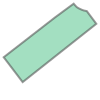

In [222]:
for len in len(range(5)):
    selected_building = building.iloc[idx[0][len]]
    selected_grid = grid.iloc[idx[1][len]]
    intersection = selected_building.geometry.intersection(selected_grid.geometry)
    
    selected_building.area


In [26]:
print(f"landuse的shape:{landuse.shape}")
print(f"grid的shape:{grid.shape}")

landuse的shape:(37614, 2)
grid的shape:(4309, 10)


In [ ]:
subgrid
for i, subgrid in grid[['gridid','geometry']].iterrows():
    possible_match_index = list(s_landuse.query(subgrid['geometry'],predicate='intersects'))
    print(landuse.iloc[possible_match_index])

In [170]:
testing_grid.intersection(landuse.iloc[test[0]].geometry.values[5])
# .sjoin(landuse.iloc[test[0]],how='left',predicates='intersects')

0    MULTIPOLYGON (((296212.604 2778379.903, 296213...
dtype: geometry

## Testing for spatial index function

In [3]:
import geopandas as gpd
import os
parent_dir = os.path.join(os.getcwd(), "..")
os.chdir(parent_dir)
# read data
landuse = gpd.read_file(
    r"input\data\land\landuse_108.gpkg", layer="landuse_108"
)

grid = gpd.read_file(
    r"input\data\population\FET_2023_grid_97.geojson"
)

In [16]:
"""Calculate LandDF"""
import constants
import pandas as pd

# mapping landuse code to landuse category code
landuse["category"] = landuse["code"].map(
    lambda code: constants.LANDUSE_CATEGORY.get(str(code), "unknown")
)


def sindex_intersection(input_data, tree_data, input_columns:list=[], tree_columns:list=[], area:bool=True, geometry:bool=True):
    """
    Using spatail index to intersect between two polygon data,
    tree_data means the data created spatial index
    input_data means the input of the function sindex.query()

    """

    columns = input_columns + tree_columns
    if area:
        columns.append("area")
    if geometry:
        columns.append("geometry")

    # create spatial index for the tree data
    sindex = tree_data.sindex
    # Using spatial index to intersects
    idx = sindex.query(input_data["geometry"], predicate="intersects")

    outputDF = pd.DataFrame(
        columns=columns
    )
    row_list = []
    for inputIdx, treeIdx in zip(idx[0], idx[1]):
        selected_input = input_data.iloc[inputIdx]
        selected_tree = tree_data.iloc[treeIdx]
        intersects = selected_input.geometry.intersection(selected_tree.geometry)

        # Eliminate the invalid geometry types and insert row data information
        row = {}
        if intersects.geom_type in ["Polygon", "MultiPolygon"]:
            if input_columns:
                for col in input_columns:
                    row[col]=selected_input[col]
            if tree_columns:
                for col in tree_columns:
                    row[col]=selected_tree[col]
            if area:
                row['area'] = intersects.area
            if geometry:
                row['geometry'] = intersects
            
            row_list.append(row)

    outputDF = pd.concat([outputDF, pd.DataFrame(row_list)],axis=0,ignore_index=True)
    return outputDF


input_columns = ['code','category']
# tree_columns = ['gridid']
df = sindex_intersection(landuse, grid, input_columns, area=True, geometry=False)

df

# row_list = []
# # Calculate by spatial index
# for index, (inputIdx, treeIdx) in enumerate(
#     zip(idx[0], idx[1])
# ):  # idx[0]:input geometry, idx[1]:tree geometry
#     row = {}
#     selected_input = landuse.iloc[inputIdx]
#     selected_tree = grid.iloc[treeIdx]
#     intersects = selected_input.geometry.intersection(selected_tree.geometry)

#     # Eliminate the invalid geometry types and create the intersection
#     if intersects.geom_type in ["Polygon", "MultiPolygon"]:
#         for col in input_columns:
#             row[col]=selected_input[col]
#         for col in tree_columns:
#             row[col]=selected_input[col]

#         if area:
#             row['area'] = intersects.area
#         if geometry:
#             row['geometry'] = intersects
        
#         row_list.append(row)

#         gridid = selected_tree["gridid"]
#         code = selected_input["code"]  # keep code for building intersection
#         category = selected_input["mapping_category"]
#         area = intersects.area
#         geometry = intersects  # keep geometry for building intersection
#         row = {
#             "gridid": gridid,
#             "code": code,
#             "category": category,
#             "area": area,
#             "geometry": geometry,
#         }
#         LandDF_list.append(new_row)

# # Keep LandDF for calculating development data
# LandDF = pd.concat([LandDF, pd.DataFrame(LandDF_list)], ignore_index=True)

,code,category,area
0,106,1,245.0
1,20200,1,50180.0
2,102,1,172.0
3,103,1,4566.0
4,20300,1,6789.0
...,...,...,...
37609,20200,1,62500.0
37610,20200,1,62500.0
37611,90200,1,1922.0
37612,20200,1,56902.0


# Testing for the zonal statistics and raster reprojection

In [3]:
import rasterstats
import rasterio as rio
import os
import geopandas as gpd

os.chdir(os.path.join(os.getcwd(),".."))
print(os.getcwd())

c:\Users\godsp\OneDrive - 國立成功大學 National Cheng Kung University\Documents\TUIC\Ubike\code_v2


In [130]:
from rasterio import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot

ndvi_fp = r"input\data\terrain\EO_Browser_images\2023-03-06-00_00_2023-03-06-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
dtm_fp = r"input\data\terrain\DTMerge.tif"
grid_fp = r"input\data\population\FET_2023_grid_97.geojson"

grid = gpd.read_file(grid_fp).set_crs('epsg:3826')
print('start')
# grid = grid.dissolve()
print('complete')

with rio.open(ndvi_fp, mode='r') as src:
    transform, width, height = calculate_default_transform(
        src.crs, {'init':'EPSG:3826'}, src.width, src.height, *src.bounds
    )
    meta = src.meta.copy()

    print(transform)
    # out_image, out_transform = mask.mask(src,grid.geometry,crop=True)
    # out_meta = src.meta
    band = src.read(1)
    
    meta.update({
        'height':height,
        'width':width,
        'transform':transform
    })





# print(out_meta)

# plot.show(out_image)

dtm_zonal = rasterstats.zonal_stats(grid,band,affine=transform,stats='mean',nodata=-999)
dtm_zonal

start
complete
| 11.51, 0.00, 295492.45|
| 0.00,-11.51, 2789161.04|
| 0.00, 0.00, 1.00|


[{'mean': 0.04581446292971777},
 {'mean': 0.04972396409216006},
 {'mean': 0.04635909109404593},
 {'mean': 0.059868027563808726},
 {'mean': 0.053645022503741376},
 {'mean': 0.05419068935113552},
 {'mean': 0.050005194428679234},
 {'mean': 0.054146254143747345},
 {'mean': 0.05111147314955146},
 {'mean': 0.05297337569199599},
 {'mean': 0.053658959005965665},
 {'mean': 0.051062555024118134},
 {'mean': 0.07985475878694873},
 {'mean': 0.0891233475740291},
 {'mean': 0.04119483695542517},
 {'mean': 0.05388244124483471},
 {'mean': 0.05293354843602036},
 {'mean': 0.05475702364582661},
 {'mean': 0.05330433727295931},
 {'mean': 0.054071211711668864},
 {'mean': 0.07911322727676265},
 {'mean': 0.09889999894071216},
 {'mean': 0.03945929945007828},
 {'mean': 0.08516666693088812},
 {'mean': 0.09940991519896453},
 {'mean': 0.12268986977821539},
 {'mean': 0.14318051689114922},
 {'mean': 0.0757725219096034},
 {'mean': 0.02547086762987878},
 {'mean': 0.041541115311551684},
 {'mean': 0.07258571277965199},
 {

In [3]:
len(dtm_zonal)

4309

In [6]:
import pandas as pd
dtm_zonal_df = pd.DataFrame(dtm_zonal,columns=['mean'])
dtm_zonal_df

,mean
0,5.733205
1,2.369112
2,3.467307
3,6.656475
4,6.995764
...,...
4304,321.022767
4305,296.695713
4306,347.069827
4307,364.311548


# Testing for point intersection function (POI and Bus)

In [88]:

import glob
import re
import pandas as pd
grid = gpd.read_file(r"input\data\population\FET_2023_grid_97.geojson")
poi_filepath_list = [file for file in glob.glob(r"input\data\POI\*.csv")]

def POI_preprocessing(poi_filepath):
    # Get the POI name by the original file name
    layer_name = "".join(
        re.search(r"poi_(.*?)\.csv", poi_filepath)
        .group(1)
        .capitalize()
        .split("_")
    )
    poi_df = pd.read_csv(poi_filepath)

    # Convert csv to GeoDataFrame
    poi_gdf = (
        gpd.GeoDataFrame(
            poi_df[['rating_num','rating']], 
            geometry=gpd.points_from_xy(poi_df.lng.astype(float),poi_df.lat.astype(float)))
            .set_crs('epsg:4326')  # original crs
            .to_crs('epsg:3826')  # destinate crs
    )

    # Intersects with grid
    poi_agg_df = (
        gpd.sjoin(
            grid[['gridid','geometry']], 
            poi_gdf, 
            predicate='intersects', 
            how='inner')
        .loc[lambda x: x['rating_num'] >= 5]  # filter the POI rating less than 5
        .groupby(['gridid']) 
        .agg({
                "rating_num":["count","sum"], # create multiIndex columns
                "rating":"sum",
        })
        .droplevel(0, axis=1)  # flatten the multiIndex columns built by agg() function
        .reset_index()  # let "gridid" as a new column instead of the index

    )
    poi_agg_df.columns = ['gridid',f"{layer_name}POICounts",f"{layer_name}POIRatingCountsSum",f"{layer_name}POIRatingStarSum"]

    poi_merge_df = (
        pd.merge(
            grid[['gridid']],
            poi_agg_df,
            on = 'gridid',
            how='left'  # keep all gridid
        )
        .fillna(0)
    )

    return poi_merge_df

poi_df = pd.DataFrame()
for filepath in poi_filepath_list:
    poi_merge_df = POI_preprocessing(filepath)
    if poi_df.empty:
        poi_df = poi_merge_df
    else:
        poi_df = pd.merge(poi_df, poi_merge_df, on='gridid')

poi_df

,gridid,ArtgalleryPOICounts,ArtgalleryPOIRatingCountsSum,ArtgalleryPOIRatingStarSum,BarPOICounts,BarPOIRatingCountsSum,BarPOIRatingStarSum,BookstorePOICounts,BookstorePOIRatingCountsSum,BookstorePOIRatingStarSum,...,ShoppingmallPOIRatingStarSum,StorePOICounts,StorePOIRatingCountsSum,StorePOIRatingStarSum,SupermarketPOICounts,SupermarketPOIRatingCountsSum,SupermarketPOIRatingStarSum,TouristattractionPOICounts,TouristattractionPOIRatingCountsSum,TouristattractionPOIRatingStarSum
0,610003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,609703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,609400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,611469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,611182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,116.0,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,597412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4305,597012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,11.0,9.3,0.0,0.0,0.0,2.0,184.0,8.1
4306,596610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4307,597413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1246.0,7.9


In [102]:
# Testing for bus route
bus_df = pd.read_csv(r"input\data\traffic\bus_station_detailed.csv")
bus_gdf = gpd.GeoDataFrame(
    bus_df[['RouteNum']],
    geometry=gpd.points_from_xy(bus_df['lon'],bus_df['lat'])
).set_crs('epsg:4326').to_crs('epsg:3826')
bus_agg_df = (
    gpd.sjoin(grid[['gridid','geometry']],bus_gdf,predicate='intersects',how='inner')
).groupby(['gridid']).agg({
    "RouteNum":'sum'
}).rename(columns={
    "sum":"BusRouteCounts"
}).reset_index()

bus_merge_df = pd.merge(grid[['gridid']], bus_agg_df, how='left',on='gridid').fillna(0)

bus_merge_df


,gridid,RouteNum
0,610003,0.0
1,609703,0.0
2,609400,0.0
3,611469,0.0
4,611182,2.0
...,...,...
4304,597412,0.0
4305,597012,2.0
4306,596610,0.0
4307,597413,2.0
